# BERTweet Fine-Tuned on Disability Subset

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Imports

In [2]:
import tensorflow as tf
tf.keras.backend.clear_session()

In [5]:
!pip install tensorflow-addons

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 591.0/591.0 kB 15.7 MB/s eta 0:00:00


In [6]:
!pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.8/6.8 MB 79.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 32.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 200.1/200.1 kB 20.4 MB/s eta 0:00:00


In [11]:
!pip3 install emoji==0.6.0

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 51.0/51.0 kB 3.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for emoji: filename=emoji-0.6.0-py3-none-any.whl size=49732 sha256=b733584bef07d0f64afd3daa83bcdbf024dac803ad6ae35edadfdfa6ac64103e
  Stored in directory: /root/.cache/pip/wheels/70/2a/7f/1a0012c86b1061c6ee2ed9568b1f830f857a51e8e416452af2
Successfully built emoji


In [44]:
!pip install pyyaml h5py  # Required to save models in HDF5 format

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
import tensorflow_addons as tfa
import transformers
from transformers import AutoTokenizer,TFRobertaModel

import pytz
import datetime
import os

/usr/local/lib/python3.9/dist-packages/tensorflow_addons/utils/tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(


## Functions and Constants

In [4]:
def to_arrays(df):
  X = df['comment_text'].to_numpy()
  y = df['toxicity_binary'].to_numpy()
  return X, y

def load_data(group):
  df_train = pd.read_csv('drive/MyDrive/data/' + group + '-dataset-train.csv')
  df_val = pd.read_csv('drive/MyDrive/data/' + group + '-dataset-val.csv')
  df_test = pd.read_csv('drive/MyDrive/data/' + group + '-dataset-test.csv')

  X_train, y_train = to_arrays(df_train)
  X_val, y_val = to_arrays(df_val)
  X_test, y_test = to_arrays(df_test)

  return X_train, y_train, X_test, y_test, X_val, y_val

In [5]:
MAX_SEQUENCE_LENGTH = 128

In [6]:
def tokenizing_pipeline(X, tokenizer):
  bert_tokenized = tokenizer(list(X),
                max_length=MAX_SEQUENCE_LENGTH,
                truncation=True,
                padding='max_length',
                return_tensors='tf')
  bert_inputs = [bert_tokenized.input_ids,
                 bert_tokenized.token_type_ids,
                 bert_tokenized.attention_mask]
  return bert_inputs

In [7]:
def build_bertweet_cls_model(max_sequence_length=MAX_SEQUENCE_LENGTH,
                          hidden_size=100, 
                          dropout=0.3,
                          learning_rate=0.0001,
                          num_train_layers=0):

    # freeze all pre-trained BERTweet layers
    if num_train_layers == 0:
      bertweet_model.trainable = False

    # partially freeze the first n pre-trained BERTweet layers
    else:
        for layer_num in range(num_train_layers):
            bertweet_model.roberta.encoder.layer[layer_num].trainable = False
    
    input_ids = tf.keras.layers.Input(shape=(max_sequence_length,), dtype=tf.int64, name='input_ids_layer')
    token_type_ids = tf.keras.layers.Input(shape=(max_sequence_length,), dtype=tf.int64, name='token_type_ids_layer')
    attention_mask = tf.keras.layers.Input(shape=(max_sequence_length,), dtype=tf.int64, name='attention_mask_layer')

    bert_inputs = {'input_ids': input_ids,
                   'token_type_ids': token_type_ids,
                   'attention_mask': attention_mask}      

    # Use the same bertweet model instance
    bert_out = bertweet_model(bert_inputs)

    cls_token = bert_out[0][:, 0, :]

    
    hidden = tf.keras.layers.Dense(hidden_size, activation='relu', name='hidden_layer')(cls_token)

    hidden = tf.keras.layers.Dropout(dropout)(hidden)  

    f1_score = tfa.metrics.F1Score(1, threshold = 0.5)

    classification = tf.keras.layers.Dense(1, activation='sigmoid', name='classification_layer')(hidden)
    
    classification_model = tf.keras.Model(inputs=[input_ids, token_type_ids, attention_mask], outputs=[classification])
    
    classification_model.compile(optimizer=tf.keras.optimizers.legacy.Adam(learning_rate=learning_rate),
                                 loss=tf.keras.losses.BinaryCrossentropy(from_logits=False), 
                                 metrics=[tf.keras.metrics.BinaryAccuracy(),
                                        tf.keras.metrics.Precision(),
                                        tf.keras.metrics.Recall(),
                                        f1_score])

    return classification_model

## Load Data

In [8]:
X_train_disability, y_train_disability, X_test_disability, y_test_disability, X_val_disability, y_val_disability = load_data('disability')

In [9]:
X_train_disability[0]

"Doesn't work? How do we know? When the country is at the point of legalizing silencers, and the right of the mentally ill to own assault weapons, it's laughable to think we have ANY gun controls."

In [10]:
X_train_disability[1]

'LoL. The mental retardation of the (d)onkeys is stunning.\nThey propose the craziest whackjob laws without one regard to the Constitution.'

## Load BERTweet Model from_pretrained() with normalization=True

In [11]:
# For transformers v4.x+:
# bertweet_tokenizer = AutoTokenizer.from_pretrained("vinai/bertweet-base", use_fast=False)
# bertweet_tokenizer_heavy = AutoTokenizer.from_pretrained("vinai/bertweet-base",
#                                                     use_fast=False,
#                                                     normalization=True,
#                                                     add_special_tokens=True,
#                                                     return_attention_mask=True)
bertweet_tokenizer = AutoTokenizer.from_pretrained("vinai/bertweet-base",
                                                    use_fast=False,
                                                    normalization=True,
                                                    add_special_tokens=True,
                                                    return_attention_mask=True)
bertweet_model = TFRobertaModel.from_pretrained("vinai/bertweet-base")

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
Some layers from the model checkpoint at vinai/bertweet-base were not used when initializing TFRobertaModel: ['lm_head']
- This IS expected if you are initializing TFRobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFRobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFRobertaModel were initialized from the model checkpoint at vinai/bertweet-base.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFRobertaModel for predictions without further training.


In [12]:
bertweet_tokenizer.tokenize(X_train_disability[1])

['LoL',
 '.',
 'The',
 'mental',
 'retar@@',
 'dation',
 'of',
 'the',
 '(',
 'd',
 ')',
 'on@@',
 'keys',
 'is',
 'stunning',
 '.',
 'They',
 'propose',
 'the',
 'craziest',
 'wha@@',
 'ck@@',
 'job',
 'laws',
 'without',
 'one',
 'regard',
 'to',
 'the',
 'Constitution',
 '.']

In [13]:
# bertweet_tokenizer_heavy.tokenize(X_train_disability[1])

In [14]:
bertweet_model.summary()

Model: "tf_roberta_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 roberta (TFRobertaMainLayer  multiple                 134899968 
 )                                                               
                                                                 
Total params: 134,899,968
Trainable params: 134,899,968
Non-trainable params: 0
_________________________________________________________________


## Tokenize Data Splits

In [15]:
# bertweet_train_inputs_disability_small = tokenizing_pipeline(X_train_disability[:100], bertweet_tokenizer) # only get the first 100 examples
# bertweet_val_inputs_disability_small = tokenizing_pipeline(X_val_disability[:50], bertweet_tokenizer) # only get the first 50 examples
# bertweet_test_inputs_disability_small = tokenizing_pipeline(X_test_disability[:20], bertweet_tokenizer) # only get the first 20 examples
bertweet_train_inputs_disability = tokenizing_pipeline(X_train_disability, bertweet_tokenizer)
bertweet_test_inputs_disability = tokenizing_pipeline(X_test_disability, bertweet_tokenizer)
bertweet_val_inputs_disability = tokenizing_pipeline(X_val_disability, bertweet_tokenizer)

In [16]:
len(X_train_disability)

12798

In [17]:
len(X_val_disability)

2134

In [18]:
len(X_test_disability)

3733

## Calculate Class Weights for Disability

Get class weights for disability train set:

In [19]:
neg, pos = np.bincount(y_train_disability)
total = neg + pos
print('Disability Examples:\n    Total: {}\n    Positive: {} ({:.2f}% of total)\n'.format(
    total, pos, 100 * pos / total))

# Scaling by total/2 helps keep the loss to a similar magnitude.
# The sum of the weights of all examples stays the same.
weight_for_0 = (1 / neg) * (total / 2.0)
weight_for_1 = (1 / pos) * (total / 2.0)

disability_class_weight = {0: weight_for_0, 1: weight_for_1}

print('Disability Weight for class 0: {:.2f}'.format(weight_for_0))
print('Disability Weight for class 1: {:.2f}'.format(weight_for_1))

Disability Examples:
    Total: 12798
    Positive: 2758 (21.55% of total)

Disability Weight for class 0: 0.64
Disability Weight for class 1: 2.32


## Build Disability Model with half-frozen BERTweet layers

In [20]:
disability_model = build_bertweet_cls_model(num_train_layers=6, learning_rate=1e-5)
disability_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 attention_mask_layer (InputLay  [(None, 128)]       0           []                               
 er)                                                                                              
                                                                                                  
 input_ids_layer (InputLayer)   [(None, 128)]        0           []                               
                                                                                                  
 token_type_ids_layer (InputLay  [(None, 128)]       0           []                               
 er)                                                                                              
                                                                                              

In [21]:
america_la_tz = pytz.timezone('America/Los_Angeles')
start_time = datetime.datetime.now(tz=america_la_tz).isoformat()
print(str(start_time))

2023-04-12T02:21:39.907948-07:00


## Define Checkpoint

In [22]:
# checkpoint_filepath = 'model_checkpoints/disability_only_best_weights.h5'
# model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
#     filepath=checkpoint_filepath,
#     verbose=1,
#     monitor='val_f1_score',
#     mode='max',
#     save_best_only=True)

# checkpoint_dir = 'drive/MyDrive/model_checkpoints/'
# checkpoint_filepath = checkpoint_dir + 'best_disability_only_weights'
# checkpoint_filepath = 'drive/MyDrive/model_checkpoints/best_disability_only_weights'
# checkpoint_filepath = 'drive/MyDrive/model_checkpoints/bestdisabilityonly-{epoch:04d}.ckpt'
checkpoint_filepath = 'drive/MyDrive/model_checkpoints/verybestdisabilityonly.hdf5'
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    verbose=1,
    monitor='val_precision',
    mode='max',
    # save_weights_only=True,
    save_best_only=True)

# BELOW ALSO WORKS
# ===============================
# checkpoint_filepath = 'drive/MyDrive/model_checkpoints/bestdisabilityonly.hdf5'
# model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
#     filepath=checkpoint_filepath,
#     verbose=1,
#     # monitor='val_f1_score',
#     # mode='max',
#     # save_weights_only=True,
#     save_best_only=True)

## Train Disability Model 

In [23]:
# FOR QUICK TESTING OF LOADING
# =============================
# disability_history = disability_model.fit(bertweet_train_inputs_disability_small,
#                                           y_train_disability[:100],
#                                           validation_data=(bertweet_val_inputs_disability_small, y_val_disability[:50]),
#                                           epochs=1,
#                                           class_weight=disability_class_weight,
#                                           callbacks=[model_checkpoint_callback])

# takes 5 min to run 1 epoch
# takes 26 min to run 5 epochs
disability_history = disability_model.fit(bertweet_train_inputs_disability,
                                          y_train_disability,
                                          validation_data=(bertweet_val_inputs_disability, y_val_disability),
                                          batch_size=32,
                                          epochs=5,
                                          class_weight=disability_class_weight,
                                          callbacks=[model_checkpoint_callback])

Epoch 1/5


400/400 [==============================] - ETA: 0s - loss: 0.5167 - binary_accuracy: 0.7447 - precision: 0.4444 - recall: 0.7371 - f1_score: 0.5545
Epoch 1: val_precision improved from -inf to 0.52261, saving model to drive/MyDrive/model_checkpoints/verybestdisabilityonly.hdf5
400/400 [==============================] - 334s 790ms/step - loss: 0.5167 - binary_accuracy: 0.7447 - precision: 0.4444 - recall: 0.7371 - f1_score: 0.5545 - val_loss: 0.4728 - val_binary_accuracy: 0.8051 - val_precision: 0.5226 - val_recall: 0.8733 - val_f1_score: 0.6539
Epoch 2/5
400/400 [==============================] - ETA: 0s - loss: 0.4013 - binary_accuracy: 0.8252 - precision: 0.5651 - recall: 0.8198 - f1_score: 0.6690
Epoch 2: val_precision did not improve from 0.52261
400/400 [==============================] - 306s 764ms/step - loss: 0.4013 - binary_accuracy: 0.8252 - precision: 0.5651 - recall: 0.8198 - f1_score: 0.6690 - val_loss: 0.5285 - val_binary_accuracy: 0.7577 - val_precision: 0.4631 - val_reca

## Plot metrics

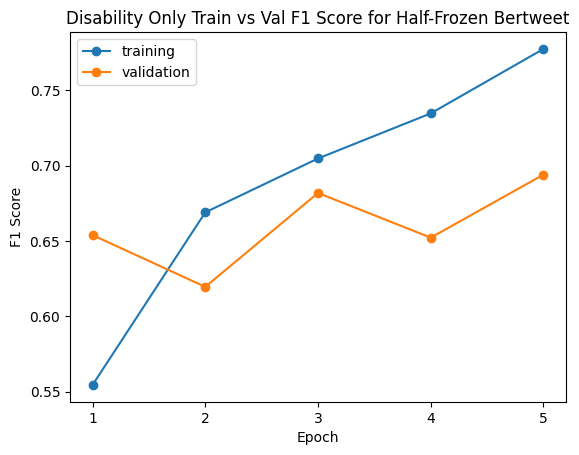

In [24]:
history = pd.DataFrame(disability_history.history)
plt.ylabel('F1 Score')
plt.xlabel('Epoch')
plt.title('Disability Only Train vs Val F1 Score for Half-Frozen Bertweet')
plt.xticks([0, 1, 2, 3, 4],['1', '2', '3', '4', '5'])
plt.plot(history['f1_score'], label="training", marker='o')
plt.plot(history['val_f1_score'], label="validation", marker='o')
plt.legend()
plt.show()

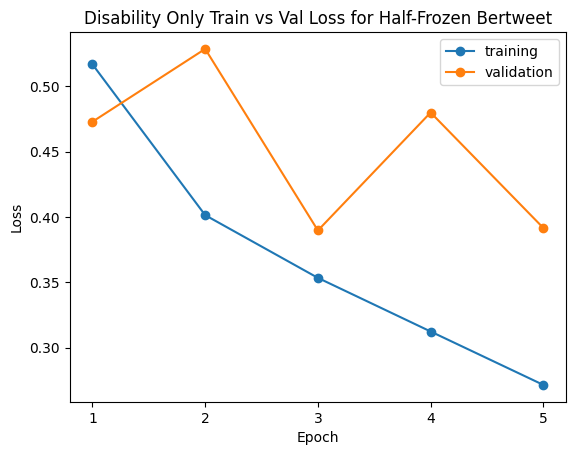

In [25]:
history = pd.DataFrame(disability_history.history)
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.title('Disability Only Train vs Val Loss for Half-Frozen Bertweet')
plt.xticks([0, 1, 2, 3, 4],['1', '2', '3', '4', '5'])
plt.plot(history['loss'], label="training", marker='o')
plt.plot(history['val_loss'], label="validation", marker='o')
plt.legend()
plt.show()

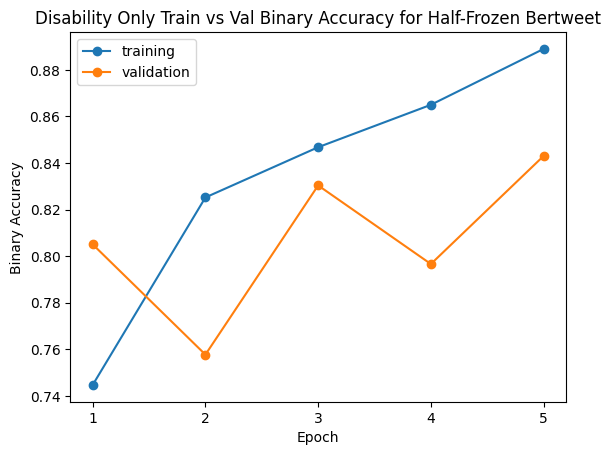

In [27]:
history = pd.DataFrame(disability_history.history)
plt.ylabel('Binary Accuracy')
plt.xlabel('Epoch')
plt.title('Disability Only Train vs Val Binary Accuracy for Half-Frozen Bertweet')
plt.xticks([0, 1, 2, 3, 4],['1', '2', '3', '4', '5'])
plt.plot(history['binary_accuracy'], label="training", marker='o')
plt.plot(history['val_binary_accuracy'], label="validation", marker='o')
plt.legend()
plt.show()

In [28]:
end_time = datetime.datetime.now(tz=america_la_tz).isoformat()
print(str(end_time))

2023-04-12T02:52:11.543404-07:00


## Evaluate Disability Model on Test Set

In [29]:
disability_test_history = disability_model.evaluate(bertweet_test_inputs_disability, y_test_disability)

117/117 [==============================] - 32s 270ms/step - loss: 0.4130 - binary_accuracy: 0.8339 - precision: 0.5619 - recall: 0.8217 - f1_score: 0.6674


## Export Results to csv

In [30]:
disability_test_history_df = pd.DataFrame({
    'test_loss': disability_test_history[0],
    'test_binary_accuracy': disability_test_history[1],
    'test_precision': disability_test_history[2],
    'test_recall': disability_test_history[3],
    'test_f1_score': disability_test_history[4]})
disability_results_df = pd.concat([pd.DataFrame(disability_history.history), disability_test_history_df], axis=0)
disability_results_df

,loss,binary_accuracy,precision,recall,f1_score,val_loss,val_binary_accuracy,val_precision,val_recall,val_f1_score,test_loss,test_binary_accuracy,test_precision,test_recall,test_f1_score
0,0.516659,0.744726,0.444372,0.737128,[0.5544798],0.472774,0.805061,0.522606,0.873333,[0.65391016],NaN,NaN,NaN,NaN,NaN
1,0.401349,0.825207,0.565109,0.819797,[0.6690339],0.528450,0.757732,0.463146,0.935556,[0.61957324],NaN,NaN,NaN,NaN,NaN
2,0.353373,0.846773,0.602574,0.848803,[0.70480204],0.389618,0.830366,0.563953,0.862222,[0.68189806],NaN,NaN,NaN,NaN,NaN
3,0.312366,0.864979,0.637114,0.867658,[0.7347252],0.479819,0.796626,0.510025,0.904444,[0.6522436],NaN,NaN,NaN,NaN,NaN
4,0.271520,0.888967,0.684211,0.900290,[0.7775169],0.391529,0.843018,0.589147,0.844444,[0.6940639],NaN,NaN,NaN,NaN,NaN
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.413022,0.833914,0.561879,0.821664,0.667382


In [32]:
disability_results_df.to_csv('drive/MyDrive/experiment_results/BERTweet_Disability_Only.csv')

## Sanity Check: Make sure we're able to load the weights from the best disability_model

Let's build another model and evaluate on the test set. Since we haven't loaded the weights yet, it should do poorly:

In [33]:
# BEFORE LOADING
test_loaded_model5 = build_bertweet_cls_model(num_train_layers=6, learning_rate=1e-5)
test_loaded_model5.evaluate(bertweet_test_inputs_disability, y_test_disability)

117/117 [==============================] - 35s 271ms/step - loss: 1.0283 - binary_accuracy: 0.2017 - precision_1: 0.2018 - recall_1: 0.9934 - f1_score: 0.3354


[1.0283199548721313,
 0.2017144411802292,
 0.2017708569765091,
 0.9933949708938599,
 array([0.3354148], dtype=float32)]

Now let's load the weights from the best disability_model and evaluate on the test set again. The results should match exactly what we got when we first evaluated disability_model on the test set:

In [34]:
# AFTER LOADING
f1_score = tfa.metrics.F1Score(1, threshold = 0.5)
test_loaded_model5.load_weights('drive/MyDrive/model_checkpoints/verybestdisabilityonly.hdf5')
test_loaded_model5.compile(optimizer=tf.keras.optimizers.legacy.Adam(learning_rate=1e-5),
                                 loss=tf.keras.losses.BinaryCrossentropy(from_logits=False), 
                                 metrics=[tf.keras.metrics.BinaryAccuracy(),
                                        tf.keras.metrics.Precision(),
                                        tf.keras.metrics.Recall(),
                                        f1_score])
test_loaded_model5.evaluate(bertweet_test_inputs_disability, y_test_disability)

117/117 [==============================] - 35s 273ms/step - loss: 0.4130 - binary_accuracy: 0.8339 - precision_2: 0.5619 - recall_2: 0.8217 - f1_score: 0.6674


[0.4130224287509918,
 0.8339137434959412,
 0.5618789792060852,
 0.8216644525527954,
 array([0.66738194], dtype=float32)]

From the disability_test_history below, we can see that we got the same results after loading the weights. This means that we successfully saved and loaded the weights! Yay!

In [35]:
disability_test_history

[0.4130224287509918,
 0.8339137434959412,
 0.5618789792060852,
 0.8216644525527954,
 array([0.66738194], dtype=float32)]